# Classification with Dirichlet prior

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.special import gammaln
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

from simplecryoem.mcmc import mcmc, accept_reject_vmap

In [2]:
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.figsize"] = 6, 6
# config.update("jax_enable_x64", True)

### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, *subkeys = random.split(key, 5)

In [4]:
K = 10
N = 1000
sigma = 0.01
alpha = jnp.ones(
    K,
)
# alpha = jnp.array([10,10,2])

In [5]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape=(N,))
print(f"pi = {pi}")

pi = [0.11671799 0.2768343  0.01061312 0.02997306 0.17172286 0.17391813
 0.11692671 0.02619359 0.07237366 0.00472651]


x = [-0.26803392 -0.7967252   2.0807824  -0.01278739 -1.9118558  -0.6346795
  0.6172751  -1.3603959   1.4652675  -0.8277637 ]


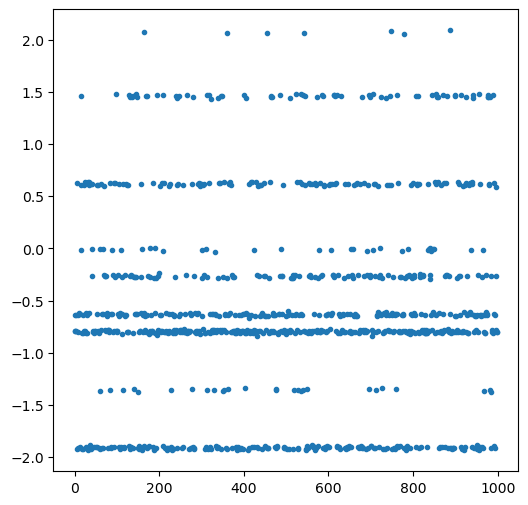

In [6]:
x = random.normal(subkeys[2], shape=(K,))
y = x[z] + sigma * random.normal(subkeys[3], shape=(N,))

print(f"x = {x}")
_ = plt.plot(y, ".")

### The posterior and proposal functions

In [7]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)

    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)

    term_mat = []
    for k in jnp.arange(K):
        logarg_k = (
            jnp.exp(-((y - x[k]) ** 2) / sigma)
            * (n_ik[:, k] + alpha[k])
            / (Nk + Ak - 1)
        )
        log_arg += logarg_k
        term_mat.append(logarg_k)

    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2)


# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_k = calc_nk_jit(z)

    term1 = jnp.sum(-((y - x[z]) ** 2) / sigma)

    logPZalpha = jnp.sum(gammaln(n_k + alpha))

    return term1 - jnp.sum(x**2) + logPZalpha


def calc_nik_ki(z, k, i):
    z = z.at[i].set(jnp.inf)
    return jnp.sum(z == k)


calc_nik_i = lambda z, i: jax.vmap(calc_nik_ki, in_axes=(None, 0, None))(
    z, jnp.arange(K), i
)
calc_nik = lambda z: jax.vmap(calc_nik_i, in_axes=(None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k: jnp.sum(z == k)
calc_nk = lambda z: jax.vmap(calc_nk_k, in_axes=(None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [8]:
# print(logPi_marg(x, z, y, sigma, alpha))
# print(logPi_marg(xi, zi, y, sigma, alpha))

In [9]:
# print(logPi(x, z, y, sigma, alpha))
# print(logPi(xi, zi, y, sigma, alpha))

In [10]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior

    p(x_1, ..., x_K | y_1, ..., y_N)

    with marginalization over z_1,...z_N."""

    x1 = random.uniform(key, x0.shape) * 2 * B - B

    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)

    r = jnp.exp((logPiX1 - logPiX0))

    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior

    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""

    x1 = random.uniform(key, x0.shape) * 2 * B - B

    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)

    r = jnp.exp((logPiX1 - logPiX0))

    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior

    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0,
    with the entry at index idx given by the proposal."""

    newval = random.uniform(key) * 2 * B - B
    x1 = x0.at[idx].set(newval)

    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)

    r = jnp.exp(logPiX1 - logPiX0)

    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_x_batch(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function for a new state x_j for all j = 1,..., K
    from the posterior

    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all z_i and the other x_i (i !=j) are fixed and with no
    marginalization over z.

    This function returns a new proposal for each x_j i.e.
    it samples x_j "one variable at a time", but for all j
    in parallel.

    The returned vector x1 is the same dimensions as x0 and contains
    the proposal states corresponding to each entry. Similarly,
    r, logPiX1 and logPiX0 are arrays of length K, each entry corresponding
    to the proposal x_j with the other x_i fixed, so that this proposal function
    can be used in the "batch" mode of the mcmc function."""

    keys = random.split(key, K)

    x1, r, logPiX1, logPiX0 = jax.vmap(
        proposal_x_idx, in_axes=(0, None, None, None, None, None, None, None, 0)
    )(keys, x0, logPiX0, B, z, y, sigma, alpha, jnp.arange(K))
    x1 = jnp.diag(x1)

    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior

    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""

    z1 = random.randint(key, z0.shape, 0, K)

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)

    r = jnp.exp(logPiX1 - logPiX0)

    return z1, r, logPiX1, logPiX0


@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior

    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.

    The returned vector z1 is equal to z0,
    with the entry at index idx given by the proposal."""

    newval = random.randint(key, (), 0, K)
    z1 = z0.at[idx].set(newval)

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)

    r = jnp.exp(logPiX1 - logPiX0)

    return z1, r, logPiX1, logPiX0


@jax.jit
def proposal_z_batch(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Batch mode proposal function for z, operating in the same
    way as proposal_x_batch.

    If the posterior depends on the states z_1,...,z_N (e.g. due to
    the Dirichlet prior), then running MCMC with this proposal function
    is NOT correct. However, this function is used in the
    proposal_z_batch_correct" function, which takes advantage of these
    parallel proposals in a proper MCMC way."""

    keys = random.split(key, N)

    # TODO: change both batch functions (this and proposal_x_batch)
    # so we don't have to do diag on an N x N (or K x K) matrix - potentially
    # problematic for large N.
    z1, r, logPiX1, logPiX0 = jax.vmap(
        proposal_z_idx, in_axes=(0, None, None, None, None, None, None, None, 0)
    )(keys, z0, logPiX0, x, y, sigma, alpha, K, jnp.arange(N))
    z1 = jnp.diag(z1)

    return z1, r, logPiX1, logPiX0


@jax.jit
def proposal_z_batch_correct(key, z0, logPiX0, x, y, sigma, alpha, K):
    """If using the Dirichlet posterior, then the proposal_z_batch is not
    proper MCMC sampling. Here, we run a number of "incorect" MCMC steps to
    sample all the entries of z in parallel, and then use the latest
    proposed z as a proposal for a "correct" MCMC proposal. The acceptance rate
    is pretty good in this toy example and the convergence great."""

    N_samples_z_local = 10
    keys = random.split(key, 2 * N_samples_z_local)
    params_z = {"x": x, "y": y, "sigma": sigma, "alpha": alpha, "K": K}

    logPiZ0 = logPi(x, z0, y, sigma, alpha)

    for i in jnp.arange(N_samples_z_local):
        z1, r, logPiX1, logPiX0 = proposal_z_batch(keys[2 * i], z0, logPiZ0, **params_z)
        a = jnp.minimum(1, r)
        unif_var = random.uniform(keys[2 * i + 1], (N,))
        z1, logPiX1 = accept_reject_vmap(unif_var, a, z0, z1, logPiX0, logPiX1)

    logPiZ1 = logPi(x, z1, y, sigma, alpha)

    r = jnp.exp(logPiZ1 - logPiZ0)

    return z1, r, logPiZ1, logPiZ0

### Sample x

In [11]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.11671799 0.2768343  0.01061312 0.02997306 0.17172286 0.17391813
 0.11692671 0.02619359 0.07237366 0.00472651]
x = [-0.26803392 -0.7967252   2.0807824  -0.01278739 -1.9118558  -0.6346795
  0.6172751  -1.3603959   1.4652675  -0.8277637 ]


In [12]:
# z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
# z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

/Users/bogdan/opt/anaconda3/envs/jax_minimal_2/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


  MCMC sample 50, posterior val = -3877.976318359375, a = 0.0
  MCMC sample 100, posterior val = -3877.976318359375, a = 0.0
  MCMC sample 150, posterior val = -3748.143798828125, a = 0.0
  MCMC sample 200, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 250, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 300, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 350, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 400, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 450, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 500, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 550, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 600, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 650, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 700, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 750, posterior val = -3362.112060546875, a = 0.0
  MCMC sample 800, posterior val = -3362.112060546875, a

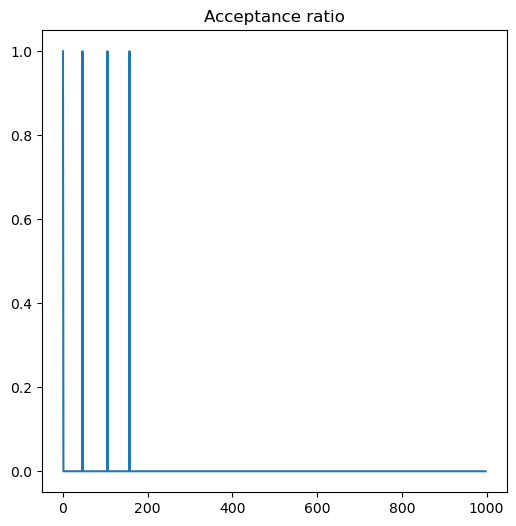

In [13]:
N_samples_x = 1000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B": B, "z": z, "y": y, "sigma": sigma, "alpha": alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r)
plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 50, posterior val = 2485.380615234375
  MCMC sample 100, posterior val = 3122.914794921875
  MCMC sample 150, posterior val = 3833.07470703125
  MCMC sample 200, posterior val = 3980.974365234375
  MCMC sample 250, posterior val = 3990.782958984375
  MCMC sample 300, posterior val = 3990.230224609375
  MCMC sample 350, posterior val = 3989.9921875
  MCMC sample 400, posterior val = 3991.96337890625
  MCMC sample 450, posterior val = 3994.066162109375
  MCMC sample 500, posterior val = 3996.540771484375
  MCMC sample 550, posterior val = 3996.98291015625
  MCMC sample 600, posterior val = 3996.17626953125
  MCMC sample 650, posterior val = 3997.058349609375
  MCMC sample 700, posterior val = 3997.14111328125
  MCMC sample 750, posterior val = 3997.431396484375
  MCMC sample 800, posterior val = 3994.0
  MCMC sample 850, posterior val = 3991.673095703125
  MCMC sample 900, posterior val = 3988.86376953125
  MCMC sample 950, posterior val = 3988.20751953125
0.589387893676757

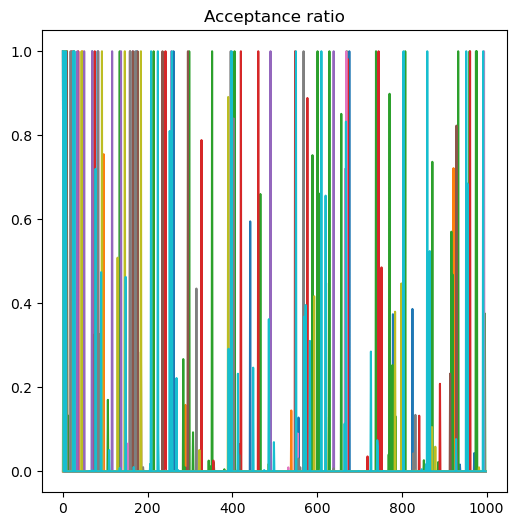

In [14]:
N_samples_x = 1000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B": B, "z": z, "y": y, "sigma": sigma, "alpha": alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, x0, N_samples_x, params_x, K, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r)
plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

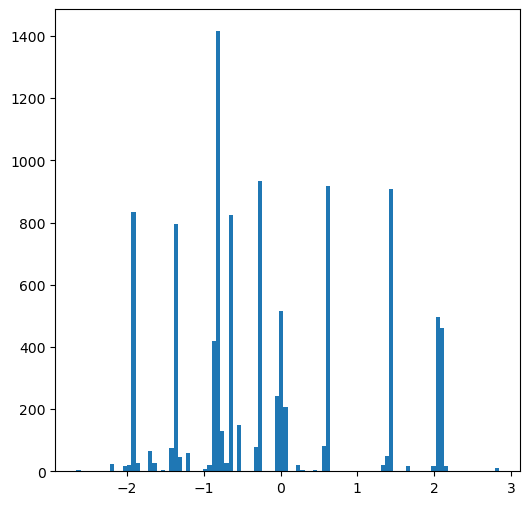

In [15]:
nbins = 100
counts, bins = np.histogram(x_samples[:, :], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

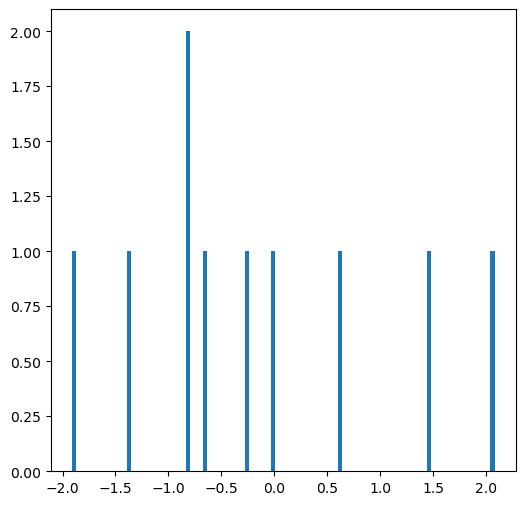

In [16]:
nbins = 100
counts, bins = np.histogram(x, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

#### One $x_i$ at a time

  MCMC sample 50, posterior val = -98881.203125, a = 0.0
  MCMC sample 100, posterior val = -98541.234375, a = 0.0
  MCMC sample 150, posterior val = -98541.234375, a = 0.0
  MCMC sample 200, posterior val = -98541.234375, a = 0.0
  MCMC sample 250, posterior val = -98540.3828125, a = 0.0
  MCMC sample 300, posterior val = -98540.3828125, a = 0.0
  MCMC sample 350, posterior val = -98540.3828125, a = 0.0
  MCMC sample 400, posterior val = -98540.3828125, a = 0.0
  MCMC sample 450, posterior val = -98536.84375, a = 0.45783334970474243
  MCMC sample 500, posterior val = -98536.84375, a = 0.0
  MCMC sample 550, posterior val = -98536.84375, a = 0.0
  MCMC sample 600, posterior val = -98536.578125, a = 0.0
  MCMC sample 650, posterior val = -98536.578125, a = 0.0
  MCMC sample 700, posterior val = -98536.578125, a = 0.0
  MCMC sample 750, posterior val = -98536.578125, a = 0.0
  MCMC sample 800, posterior val = -98536.578125, a = 0.0
  MCMC sample 850, posterior val = -98536.578125, a = 0.

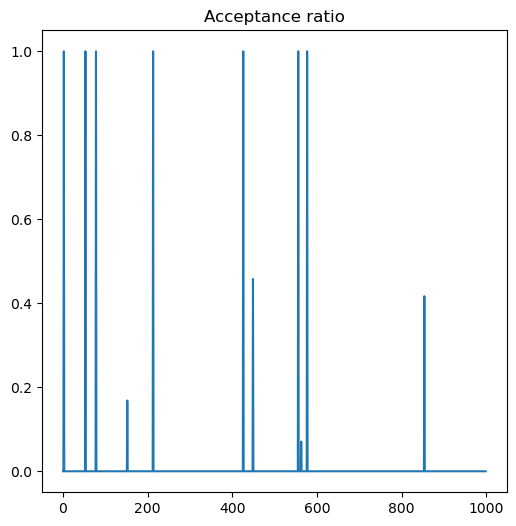

In [17]:
N_samples_x = 1001
B = 3

idx = 1
x0 = jnp.array(np.random.randn(K))

params_x = {"B": B, "z": z, "y": y, "sigma": sigma, "alpha": alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r)
plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

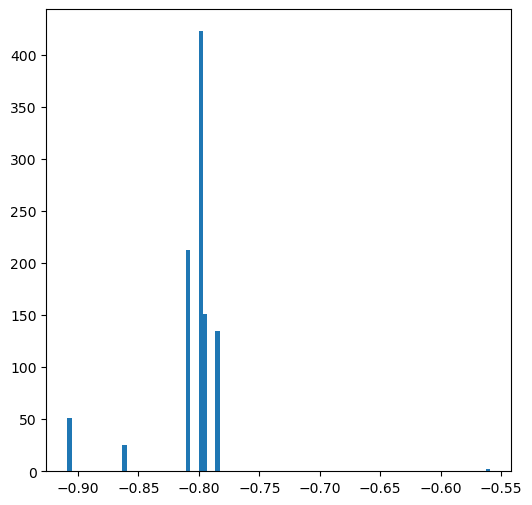

In [18]:
nbins = 100
counts, bins = np.histogram(x_samples[:, idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

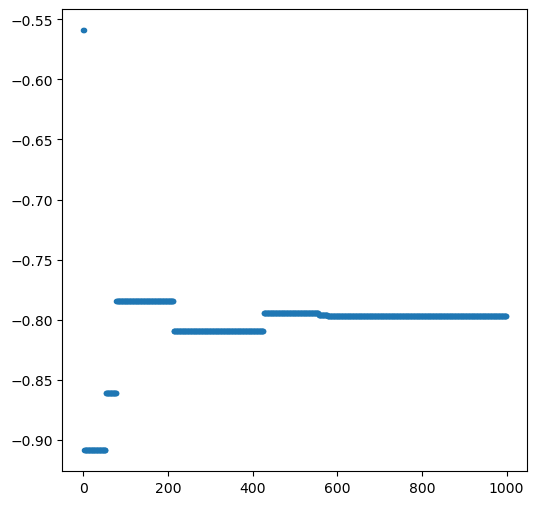

In [19]:
plt.plot(x_samples[:, idx], ".")

### Sample z

In [20]:
N_samples_z = 1000
z0 = jnp.array(np.random.randint(0, K, (N,)))
# z0 = z.at[idx].set(np.random.randint(0,K,()))

B = 2
idx = 10
# params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}
params_z = {"x": x, "y": y, "sigma": sigma, "alpha": alpha, "K": K}

key, subkey = random.split(key)

t0 = time.time()
# z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)
z_mean, z_r, z_samples = mcmc(
    subkey, proposal_z_batch_correct, z0, N_samples_z, params_z, 1, 1
)

z_rec = z_samples[N_samples_z - 2]
print(f"{time.time()-t0} sec")
# plt.plot(z_r); plt.title("Acceptance ratio")

  MCMC sample 50, posterior val = 3743.7626953125, a = 2.5710694899316877e-05
  MCMC sample 100, posterior val = 3891.412109375, a = 2.3097612938727252e-05
  MCMC sample 150, posterior val = 3961.3115234375, a = 0.2669214606285095
  MCMC sample 200, posterior val = 3986.214599609375, a = 0.0053236521780490875
  MCMC sample 250, posterior val = 3998.431396484375, a = 0.0055601028725504875
  MCMC sample 300, posterior val = 3997.96826171875, a = 0.004184707999229431
  MCMC sample 350, posterior val = 4005.352294921875, a = 0.07709289342164993
  MCMC sample 400, posterior val = 4009.419921875, a = 0.00021276500774547458
  MCMC sample 450, posterior val = 4007.489990234375, a = 0.023575231432914734
  MCMC sample 500, posterior val = 4008.666259765625, a = 0.07617613673210144
  MCMC sample 550, posterior val = 4006.54833984375, a = 2.4010549282138527e-07
  MCMC sample 600, posterior val = 4012.231689453125, a = 6.941937044757651e-06
  MCMC sample 650, posterior val = 4013.395751953125, a = 

In [21]:
jnp.sum(jnp.abs(z_rec - z))

Array(48, dtype=int32)

In [22]:
jnp.sum(jnp.abs(z0 - z))

Array(3142, dtype=int32)

In [23]:
print(jnp.sum(jnp.abs(z0 - z)))
print(jnp.sum(jnp.abs(z_samples[N_samples_z - 2, :] - z)))

3142
48


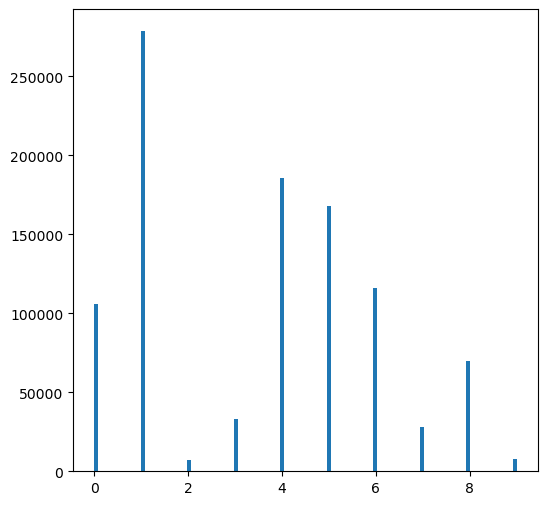

In [24]:
nbins = 100
counts, bins = np.histogram(z_samples[:, :], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

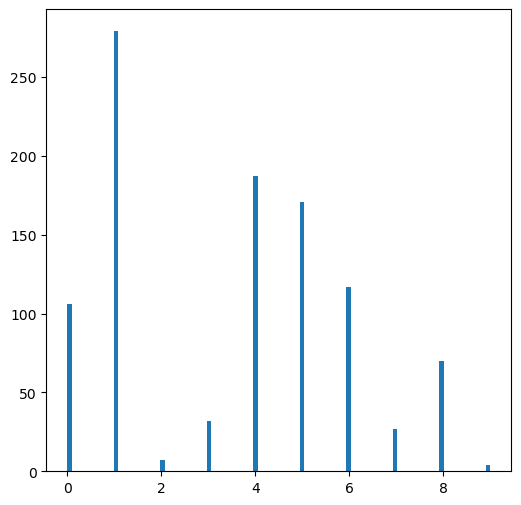

In [25]:
nbins = 100
counts, bins = np.histogram(z, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [26]:
N_iters = 10
N_samples_z = 301  # 300
N_samples_x = 1001
B = 3

sample_x = True
sample_z = True
search_z = False

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

# xi = x
# zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")

        params_x = {"B": B, "z": zi, "y": y, "sigma": sigma, "alpha": alpha}

        key, subkey = random.split(key)

        # t0 = time.time()
        x_mean, x_r, x_samples = mcmc(
            subkey, proposal_x_batch, xi, N_samples_x, params_x, K, 1
        )
        # x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1)

        xi = x_samples[N_samples_x - 2]

    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k

    if sample_z:
        print("  Sampling z")
        # for idx_z in tqdm(jnp.arange(N)):

        # params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}
        params_z = {"x": xi, "y": y, "sigma": sigma, "alpha": alpha, "K": K}

        key, subkey = random.split(key)

        # z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)
        # z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch, zi, N_samples_z, params_z, N, 1)
        z_mean, z_r, z_samples = mcmc(
            subkey, proposal_z_batch_correct, zi, N_samples_z, params_z, 1, 1
        )

        zi = z_samples[N_samples_z - 2]

print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 50, posterior val = -84987.6171875
  MCMC sample 100, posterior val = -84709.5234375
  MCMC sample 150, posterior val = -84704.6328125
  MCMC sample 200, posterior val = -84658.8984375
  MCMC sample 250, posterior val = -84637.4921875
  MCMC sample 300, posterior val = -84634.8203125
  MCMC sample 350, posterior val = -84628.2109375
  MCMC sample 400, posterior val = -84626.1953125
  MCMC sample 450, posterior val = -84621.7578125
  MCMC sample 500, posterior val = -84616.078125
  MCMC sample 550, posterior val = -84615.9375
  MCMC sample 600, posterior val = -84615.7265625
  MCMC sample 650, posterior val = -84603.2734375
  MCMC sample 700, posterior val = -84604.2734375
  MCMC sample 750, posterior val = -84604.484375
  MCMC sample 800, posterior val = -84604.484375
  MCMC sample 850, posterior val = -84603.4765625
  MCMC sample 900, posterior val = -84603.4765625
  MCMC sample 950, posterior val = -84603.3515625
  MCMC sample 1000, posterior val =

454
70
27
117
32
106
7
0
187
0


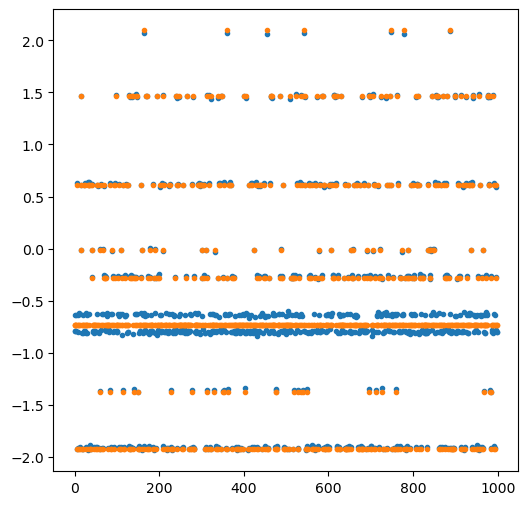

In [27]:
plt.plot(y, ".")
plt.plot(xi[zi], ".")

for k in jnp.arange(K):
    print(jnp.sum(zi == k))

In [28]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

4000.666
4019.1567


In [29]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

Array(1., dtype=float32)

106
279
7
32
187
171
117
27
70
4


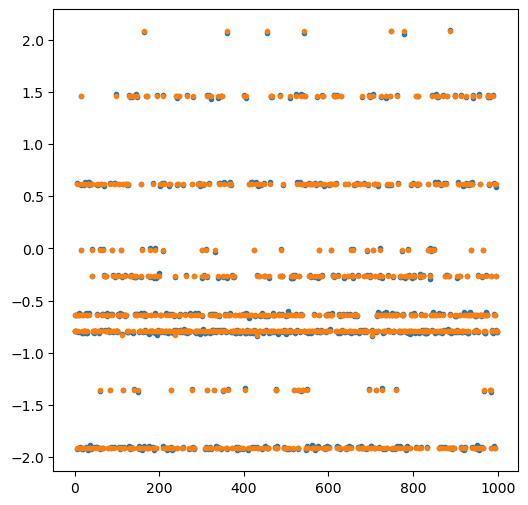

In [30]:
plt.plot(y, ".")
plt.plot(x[z], ".")

for k in jnp.arange(K):
    print(jnp.sum(z == k))

In [31]:
print(pi)
print(x)
print(xi)

[0.11671799 0.2768343  0.01061312 0.02997306 0.17172286 0.17391813
 0.11692671 0.02619359 0.07237366 0.00472651]
[-0.26803392 -0.7967252   2.0807824  -0.01278739 -1.9118558  -0.6346795
  0.6172751  -1.3603959   1.4652675  -0.8277637 ]
[-0.734426    1.4668372  -1.3771827   0.6136129  -0.01387167 -0.2802093
  2.0961242  -1.8388746  -1.9257274  -0.53975844]


In [32]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y) ** 2 * pi[z]


def loss_fun_vmap(x, z, y):
    n_k = calc_nk_jit(z)
    logPZalpha = jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return (
        jnp.sum(jax.vmap(loss_fun, in_axes=(None, 0, 0))(x, z, y))
        + jnp.sum(x**2)
        - logPZalpha
    )

In [33]:
n_k = calc_nk_jit(z)
logPZalpha = jnp.sum(gammaln(n_k + alpha))

In [34]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

logPZalpha = -3641.732666015625
-3434.7568
logPZalpha = -4342.4775390625
-4325.3037
logPZalpha = -4025.618896484375
-4011.4424


### Some functions used for debugging - ignore

In [35]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

9
0.0009027998


In [36]:
key, subkey = random.split(key)
# z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

[[0.10604559 0.2765114  0.00792864 ... 0.02775025 0.0703667  0.0049554 ]
 [0.10604559 0.27750248 0.00792864 ... 0.02775025 0.0703667  0.0049554 ]
 [0.10604559 0.2765114  0.00792864 ... 0.02775025 0.0703667  0.0049554 ]
 ...
 [0.10604559 0.2765114  0.00792864 ... 0.02775025 0.0703667  0.0049554 ]
 [0.10604559 0.2765114  0.00792864 ... 0.02775025 0.0703667  0.0049554 ]
 [0.10604559 0.2765114  0.00792864 ... 0.02775025 0.0703667  0.0049554 ]]


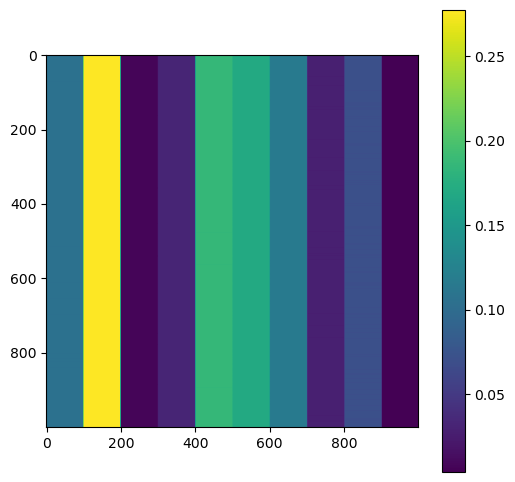

In [37]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k]) / (Nk + Ak - 1))
    probs_dn.append((n_ik_z[:, k]) / (Nk - 1))

probs_d = jnp.array(probs_d).transpose()
probs_dn = jnp.array(probs_dn).transpose()

print(probs_d)
# print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N / K), axis=1))
plt.colorbar()

In [38]:
myf = lambda x0, x1: logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3, 3, 1000)
yy = jnp.linspace(-3, 3, 1000)

In [39]:
myf_x = jax.jit(lambda x: jax.vmap(myf, in_axes=(None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

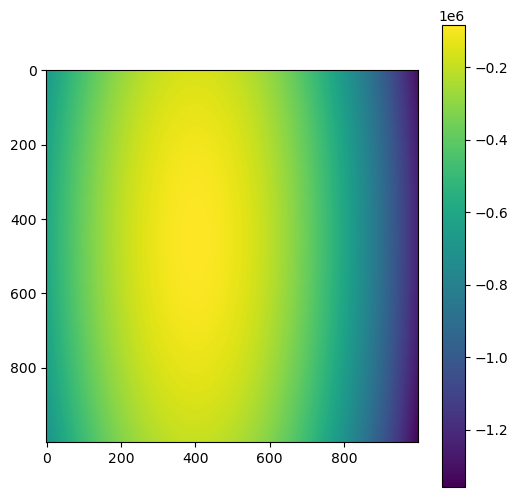

In [40]:
plt.imshow((myf_xy))
plt.colorbar()

In [41]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

01 -87461.33
00 -94185.98
11 -90433.62
10 -97158.25


In [42]:
myf(x[0], x[1])

Array(-87461.33, dtype=float32)

In [43]:
jnp.max(myf_xy)

Array(-84124.02, dtype=float32)